In [0]:
!pip install python-dateutil==2.8.1
# Installing the PyDrive in Python Environment in Colab
!pip install -U -q PyDrive
!pip install landsatxplore
!pip install pylandsat
!pip install shapely
!pip install geopandas
!pip install rasterio
!pip install geomac-wildfires
!pip install rio_toa
!nvidia-smi

# Importing the necessary libraries for google drive authentication
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Data imports
import sqlalchemy
import pandas as pd
print(pd.__version__) 
import numpy as np
import sklearn
import gzip
import datetime
from tqdm import tqdm
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle
import random
random.seed(42)

# Authenticate to google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def download_from_drive(drive_link, filename):
  """
  Loads a drive file into local storage for access. Once this method is called,
  a file can be accessed as if it were a local file.

  drive_link: the url of the file on google drive
  filename: the file's filename
  """
  drive_id = drive_link.split('=')[1]
  downloaded = drive.CreateFile({'id':drive_id })
  downloaded.GetContentFile(filename)
def upload_file(filepath):
  """
  Uploads the given file to our drive folder.
  """
  print(f"Uploading {filepath} to drive...")
#   f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": '[INSERT ID HERE]'}]})
  f.SetContentFile(filepath)
  f.Upload()

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

0.25.3


1. Get fire data. 
2. Filter fire data:
  1. Remove fires with 
3. For each fire:
  1. Get scenes during the fire, with only uncloudy scenes (< k = 10?)
  2. Sample n before/after scene pairs from fire
  3. For m rectangle samples in each pair:
    1. Mask pairs to sample
    2. Calculate on_fire layer
    3. Toss out if not on fire
  5. Save pairs to fire
4. Save fire dataframe

Connecting to database...
Reading data from database...
   FIRE_YEAR  CONT_DATE STAT_CAUSE_DESCR  ...  STATE  DISCOVERY_DATE FIRE_SIZE
0       2005  2453403.5    Miscellaneous  ...     CA       2453403.5      0.10
1       2004  2453137.5        Lightning  ...     CA       2453137.5      0.25
2       2004  2453156.5   Debris Burning  ...     CA       2453156.5      0.10
3       2004  2453189.5        Lightning  ...     CA       2453184.5      0.10
4       2004  2453189.5        Lightning  ...     CA       2453184.5      0.10

[5 rows x 8 columns]
FIRE_YEAR                    2005
CONT_DATE              2.4534e+06
STAT_CAUSE_DESCR    Miscellaneous
LATITUDE                  40.0369
LONGITUDE                -121.006
STATE                          CA
DISCOVERY_DATE         2.4534e+06
FIRE_SIZE                     0.1
Name: 0, dtype: object
Cleaning data...
         FIRE_YEAR  CONT_DATE  ...   FIRE_SIZE  FIRE_DURATION
1804783       2015 2015-09-29  ...  488.934844             99

[1 rows x 9

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49a65c7898>,
      dtype=object)

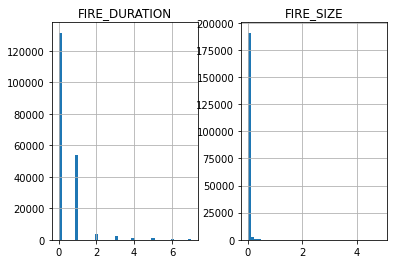

In [0]:
db_link = 'https://drive.google.com/open?id=1Fcq2Xz1iWqkYrPSlgIx4ibMmAxZfth7a'
db_filename = "fpa_fod.sqlite"
download_from_drive(db_link, db_filename)

print("Connecting to database...")
engine = sqlalchemy.create_engine('sqlite:///./fpa_fod.sqlite')
conn = engine.connect()

print("Reading data from database...")
df = pd.read_sql_query("SELECT FIRE_YEAR,CONT_DATE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", conn)
print(df.head()) #check the data
print(df.iloc[0])

def clean_unmapped_fires(df):
  epoch = pd.to_datetime(0, unit='s').to_julian_date()
  df['CONT_DATE'] = pd.to_datetime(df['CONT_DATE'] - epoch, unit='D')
  df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - epoch, unit = 'D')
  df['FIRE_DURATION'] = df['CONT_DATE'] - df['DISCOVERY_DATE']
  df['FIRE_DURATION'] = df['FIRE_DURATION'].dt.days
  df['FIRE_DURATION'].fillna(df['FIRE_DURATION'].mean(),inplace = True)
  df['FIRE_DURATION'] = df['FIRE_DURATION'].apply(lambda x : int(x))
  # Convert acres to miles
  df['FIRE_SIZE'] = df['FIRE_SIZE'] / 640
  # Landsat has temporal resolution of 16 days, we need fires longer than this (is this true?? maybe overlapping scenes that contain a given point every ~2-3 days)
  # df = df[df['FIRE_DURATION'] >= 16]
  # Landsat launched on February 11, 2013
  df = df[df['DISCOVERY_DATE'] > '2013-02-11']
  return df
print("Cleaning data...")
df = clean_unmapped_fires(df)
print(df[df['FIRE_SIZE'] == max(df['FIRE_SIZE'])])
print("There are %d fires after cleaning." % (df.shape[0]))

print("Largest fire:")
print(df[df['FIRE_SIZE'] == max(df['FIRE_SIZE'])][['DISCOVERY_DATE', 'CONT_DATE', 'LATITUDE', 'LONGITUDE', 'FIRE_SIZE']])
print("Longest fire:")
print(df[df['FIRE_DURATION'] == max(df['FIRE_DURATION'])][['DISCOVERY_DATE', 'CONT_DATE', 'LATITUDE', 'LONGITUDE', 'FIRE_SIZE']])
print("Random fires:")
print(df.sample(5)[['DISCOVERY_DATE', 'CONT_DATE', 'LATITUDE', 'LONGITUDE', 'FIRE_SIZE']])

plot_cols = df[['FIRE_SIZE', 'FIRE_DURATION']]
plot_cols = plot_cols[(plot_cols['FIRE_SIZE'] < 2) & (plot_cols['FIRE_DURATION'] < 8)]
print("Plotting " + str(plot_cols.shape[0]/df.shape[0]*100) + "% of the data")
plot_cols.hist(bins=40)

# Create smaller df to work with
#df = df[df['DISCOVERY_DATE'].dt.year == 2008].head(10000)
#print(df.shape[0])
#print(df.head())

In [0]:
import landsatxplore.api
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
from landsatxplore.earthexplorer import EarthExplorer

import os
from glob import glob # File manipulation
import numpy as np
import geopandas as gpd
import rasterio as rio
from rio_toa import reflectance
import tarfile

# LANDSAT_USERNAME = LANDSAT USERNAME
# LANDSAT_PASSWORD = LANDSAT PASSWORD

ee = EarthExplorer(LANDSAT_USERNAME, LANDSAT_PASSWORD)

# Initialize a new API instance and get an access key
api = landsatxplore.api.API(LANDSAT_USERNAME, LANDSAT_PASSWORD)

# Map from important band numbers to their index in the saved combined files
#B1 - deep blue/violet (fire detection)
#B2 - blue (firecast)
#B3 - green (firecast)
#B4 - red (firecast)
#B5 - near infrared light (fire detection, firecast)
#B6 - swir (fire detection)
#B7 - swir (fire detection)
#B8 - all light
#B9 - clouds
#B10 - thermal infrared (?)
#B11 - thermal infrared (?)
#BQA - quality assessment (?)
#ANG.txt (?)
#MTL.txt
bands_to_keep = [1, 2, 3, 4, 5, 6, 7]
all_bands = ["B" + str(band) for band in bands_to_keep] + ["NDVI", "FIRE"]
band_indices = {b: i for i, b in enumerate(all_bands)}

def dn_to_toa(output_dir, file_id):
  print("Converting to TOA...")
  creation_options = {'nodata': 0,
                    'compress': 'deflate',
                    'predict': 2}
  processes = 4
  rescale_factor = 55000
  dtype = 'uint16'
  src_mtl = glob(os.path.join(output_dir, '*MTL*'))[0]
  for band in tqdm(bands_to_keep):
    src_path = os.path.join(output_dir, file_id + "_B" + str(band) + ".TIF")
    dst_path = os.path.join(output_dir, 'TOA' + "_B" + str(band) + '.TIF')
    reflectance.calculate_landsat_reflectance([src_path], src_mtl, 
                                                        dst_path,
                                                        rescale_factor=rescale_factor, 
                                                        creation_options=creation_options,
                                                        bands=[band], dst_dtype=dtype,
                                                        processes=processes, 
                                                        pixel_sunangle=True)
    os.rename(src_path, os.path.join(output_dir, file_id + "_B" + str(band) + "unprocessed.TIF"))
    os.rename(dst_path, src_path)

def normalize(array):
    array_min, array_max = array.min(), array.max()
    print(array_min, array_max)
    return (array - array_min) / (array_max - array_min)
    #return array

def find_scenes(latitude, longitude, start_date, end_date):
  #start_date = datetime.strptime(end_date, '%Y-%m-%d') + relativedelta(years=-1)
  #start_date = datetime.strftime(start_date, '%Y-%m-%d')
  #each scene 115 miles long and 115 miles wide (or 100 nautical miles long and 100 nautical miles wide, or 184 kilometers long and 184 kilometers wide
  scenes = api.search(
      dataset='LANDSAT_8_C1',
      latitude=latitude,
      longitude=longitude,
      start_date=start_date,
      end_date=end_date,
      max_cloud_cover=30, # % out of 100
      max_results=50)
  print('{} scenes found.'.format(len(scenes)))
  for scene in scenes:
    print(scene['acquisitionDate'])
  return scenes
  #latest_scehe = max(scenes, key=lambda d: datetime.strptime(d['acquisitionDate'], '%Y-%m-%d'))
  
  #return latest_scehe

def calculate_band_info(output_dir, file_id):
  print("Calculating auxillary bands...")
  with rio.open(os.path.join(output_dir, file_id + "_B1.TIF")) as deep_blue_file, \
       rio.open(os.path.join(output_dir, file_id + "_B4.TIF")) as red_file, \
       rio.open(os.path.join(output_dir, file_id + "_B5.TIF")) as nir_file, \
       rio.open(os.path.join(output_dir, file_id + "_B6.TIF")) as swir6_file, \
       rio.open(os.path.join(output_dir, file_id + "_B7.TIF")) as swir7_file:

    meta = deep_blue_file.meta
    meta.update(dtype=rio.float64)

    # Calculate normalized difference vegetation index (NDVI)
    red = red_file.read()
    nir = nir_file.read()
    ndvi = np.divide((nir + red), (nir - red), out=np.zeros_like(nir, dtype=float), where=(nir - red)!=0)

    ndvi = np.squeeze(ndvi, 0)
    ndvi_filename = os.path.join(output_dir, file_id + "_NDVI" + ".TIF")
    with rio.open(ndvi_filename, 'w', **meta) as ndvi_file:
      ndvi_file.write(ndvi, 1)

    # Calculate on-fire pixels assuming image taken during daytime (https://www.sciencedirect.com/science/article/pii/S0034425715301206)
    fire_filename = os.path.join(output_dir, file_id + "_FIRE" + ".TIF")
    deep_blue = deep_blue_file.read()
    swir6 = swir6_file.read()
    swir7 = swir7_file.read()
    r75 = np.divide(swir7, nir, out=np.zeros_like(swir7, dtype=float), where=nir!=0)
    r76 = np.divide(swir7, swir6, out=np.zeros_like(swir7, dtype=float), where=swir6!=0)
    fire = (r75 > 2.5) & (swir7 - nir > 0.3) & (swir7 > 0.5)
    folded_fires = (swir6 > 0.8) & (deep_blue < 0.2) & ((nir > 0.4) | (swir7 < 0.1))
    fire = (fire | folded_fires).astype(np.float64)

    fire = np.squeeze(fire, 0)
    fire_filename = os.path.join(output_dir, file_id + "_FIRE" + ".TIF")
    with rio.open(fire_filename, 'w', **meta) as fire_file:
      fire_file.write(fire, 1)


def download_scene_sat_image(scene):
  """
  Given information for a scene, downloads the image data into data/{scene['displayId']}/{scene['displayId']}_combined.TIF.
  Also saves the scene dictionary into a pickled file in the same directory with the name scene.pickle.
  """
  if not os.path.isdir("data"):
    print("Data directory does not exist")
    return

  file_id = scene['displayId']
  output_dir = os.path.join('./data', file_id)
  try: 
    os.mkdir(output_dir) 
  except OSError:
    # Directory already exists, so we already downloaded image 
    #pass
    return
  landsat_file = os.path.join(output_dir, file_id + ".tar.gz")
  # Save scene to file
  print(scene)
  with open(os.path.join(output_dir, 'scene.pickle'), 'wb') as handle:
    pickle.dump(scene, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print("Downloading " + landsat_file + "...")
  if not os.path.exists(landsat_file):
    download_from_drive("https://drive.google.com/open?id=15xntU-V4a1LDM8tS6zgYDf4G0-qui86s", "./data/LC08_L1TP_046028_20130820_20170309_01_T1/LC08_L1TP_046028_20130820_20170309_01_T1.tar.gz")
    #ee.download(scene_id=file_id, output_dir=output_dir)
    #upload_file(landsat_file)
  # Extract files
  !ls data/LC08_L1TP_046028_20130820_20170309_01_T1/
  tar = tarfile.open(landsat_file)
  tar.extractall(output_dir)
  tar.close()
  #os.remove(landsat_file)
  # Remove useless bands
  for band in ["_B8.TIF", "_B9.TIF", "_BQA.TIF", "_B10.TIF", "_B11.TIF", "_ANG.txt"]:
    os.remove(os.path.join(output_dir, file_id + band))
  dn_to_toa(output_dir, file_id)
  calculate_band_info(output_dir, file_id)
  # Stack good bands into combined file
  file_list = [os.path.join(output_dir, file_id + "_" + band + ".TIF") for band in all_bands]
  output = os.path.join(output_dir, file_id + "_combined.TIF")
  #stack_bands(file_list, output)
  # Remove good band files
  #for f in file_list:
  #  os.remove(f)

def stack_bands(file_list, result_file):
  """
  Takes bands stored individually in files in file_list, and stacks them into 
  a new file stored in result_file.
  """
  # Read metadata of first file
  with rio.open(file_list[0]) as src0:
      meta = src0.meta
  print(meta)
  # Update meta to reflect the number of layers
  meta.update(count = len(file_list))
  meta.update(dtype=rio.float64)
  # Read each layer and write it to combined file
  with rio.open(result_file, 'w', **meta) as dst:
      for id, layer in enumerate(file_list, start=1):
        with rio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [0]:
!rm -rf data
#output_dir = "data/LC08_L1TP_075014_20150805_20170226_01_T1"
#for f in glob(os.path.join(output_dir, '*.TIF')):
#  os.remove(f)
#os.remove("data/LC08_L1TP_075014_20150805_20170226_01_T1/LC08_L1TP_075014_20150805_20170226_01_T1_combined.TIF")

#file_id = "LC08_L1TP_075014_20150805_20170226_01_T1"
#file_list = [os.path.join(output_dir, file_id + "_" + band + ".TIF") for band in all_bands]
#output = os.path.join(output_dir, file_id + "_combined.TIF")
#stack_bands(file_list, output)
!mkdir data
#calculate_band_info("data/LC08_L1TP_075014_20150805_20170226_01_T1/", "LC08_L1TP_075014_20150805_20170226_01_T1")
#!cat data/LC08_L1TP_075014_20150805_20170226_01_T1/LC08_L1TP_075014_20150805_20170226_01_T1_MTL.txt
#for i in range(500):
#  print(i)
#  fire = df.iloc[i]
#  scenes = find_scenes(fire['LATITUDE'], fire['LONGITUDE'], fire['DISCOVERY_DATE'].strftime('%Y-%m-%d'), fire['CONT_DATE'].strftime('%Y-%m-%d'))
#  if len(scenes) != 0:
#    print("Found")

fire = df.iloc[44]
scenes = find_scenes(fire['LATITUDE'], fire['LONGITUDE'], fire['DISCOVERY_DATE'].strftime('%Y-%m-%d'), fire['CONT_DATE'].strftime('%Y-%m-%d'))
scene = scenes[0]
displayId = scene["displayId"]
download_scene_sat_image(scene)
!ls data/LC08_L1TP_046028_20130820_20170309_01_T1/
filename = f"data/{displayId}/{displayId}_combined.TIF"

2 scenes found.
2013-08-20
2013-08-20
{'acquisitionDate': '2013-08-20', 'startTime': '2013-08-20', 'endTime': '2013-08-20', 'spatialFootprint': {'type': 'Polygon', 'coordinates': [[[-123.8733, 45.38132], [-121.51671, 44.95235], [-120.84734, 46.65685], [-123.27634, 47.09037], [-123.8733, 45.38132]]]}, 'sceneBounds': '-123.8733,44.95235,-120.84734,47.09037', 'browseUrl': 'https://ims.cr.usgs.gov/browse/landsat_8_c1/2013/046/028/LC08_L1TP_046028_20130820_20170309_01_T1.jpg', 'dataAccessUrl': 'https://earthexplorer.usgs.gov/order/process?dataset_name=LANDSAT_8_C1&ordered=LC80460282013232LGN01&node=INVSVC', 'downloadUrl': 'https://earthexplorer.usgs.gov/download/external/options/LANDSAT_8_C1/LC80460282013232LGN01/INVSVC/', 'entityId': 'LC80460282013232LGN01', 'displayId': 'LC08_L1TP_046028_20130820_20170309_01_T1', 'cloudCover': 1.56, 'metadataUrl': 'https://earthexplorer.usgs.gov/metadata/xml/12864/LC80460282013232LGN01/', 'fgdcMetadataUrl': 'https://earthexplorer.usgs.gov/fgdc/12864/LC804

  0%|          | 0/7 [00:00<?, ?it/s]

Converting to TOA...


100%|██████████| 7/7 [01:12<00:00, 10.17s/it]


Calculating auxillary bands...
LC08_L1TP_046028_20130820_20170309_01_T1_B1.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B1unprocessed.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B2.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B2unprocessed.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B3.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B3unprocessed.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B4.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B4unprocessed.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B5.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B5unprocessed.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B6.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B6unprocessed.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B7.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_B7unprocessed.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_FIRE.TIF
LC08_L1TP_046028_20130820_20170309_01_T1_MTL.txt
LC08_L1TP_046028_20130820_20170309_01_T1_NDVI.TIF
LC08_L1TP_046028_20130820_20170309_01_T1.tar.gz
scene.pickle


<open DatasetReader name='data/LC08_L1TP_046028_20130820_20170309_01_T1/LC08_L1TP_046028_20130820_20170309_01_T1_B4.TIF' mode='r'>
BoundingBox(left=431385.0, bottom=4978485.0, right=664815.0, top=5215515.0)
597572.7484609081 4989745.372495639
1172 8428
<open DatasetReader name='data/LC08_L1TP_046028_20130820_20170309_01_T1/LC08_L1TP_046028_20130820_20170309_01_T1_B3.TIF' mode='r'>
BoundingBox(left=431385.0, bottom=4978485.0, right=664815.0, top=5215515.0)
597572.7484609081 4989745.372495639
2167 6260
<open DatasetReader name='data/LC08_L1TP_046028_20130820_20170309_01_T1/LC08_L1TP_046028_20130820_20170309_01_T1_B2.TIF' mode='r'>
BoundingBox(left=431385.0, bottom=4978485.0, right=664815.0, top=5215515.0)
597572.7484609081 4989745.372495639
3402 6095
<open DatasetReader name='data/LC08_L1TP_046028_20130820_20170309_01_T1/LC08_L1TP_046028_20130820_20170309_01_T1_B4unprocessed.TIF' mode='r'>
BoundingBox(left=431385.0, bottom=4978485.0, right=664815.0, top=5215515.0)
597572.7484609081 49897

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


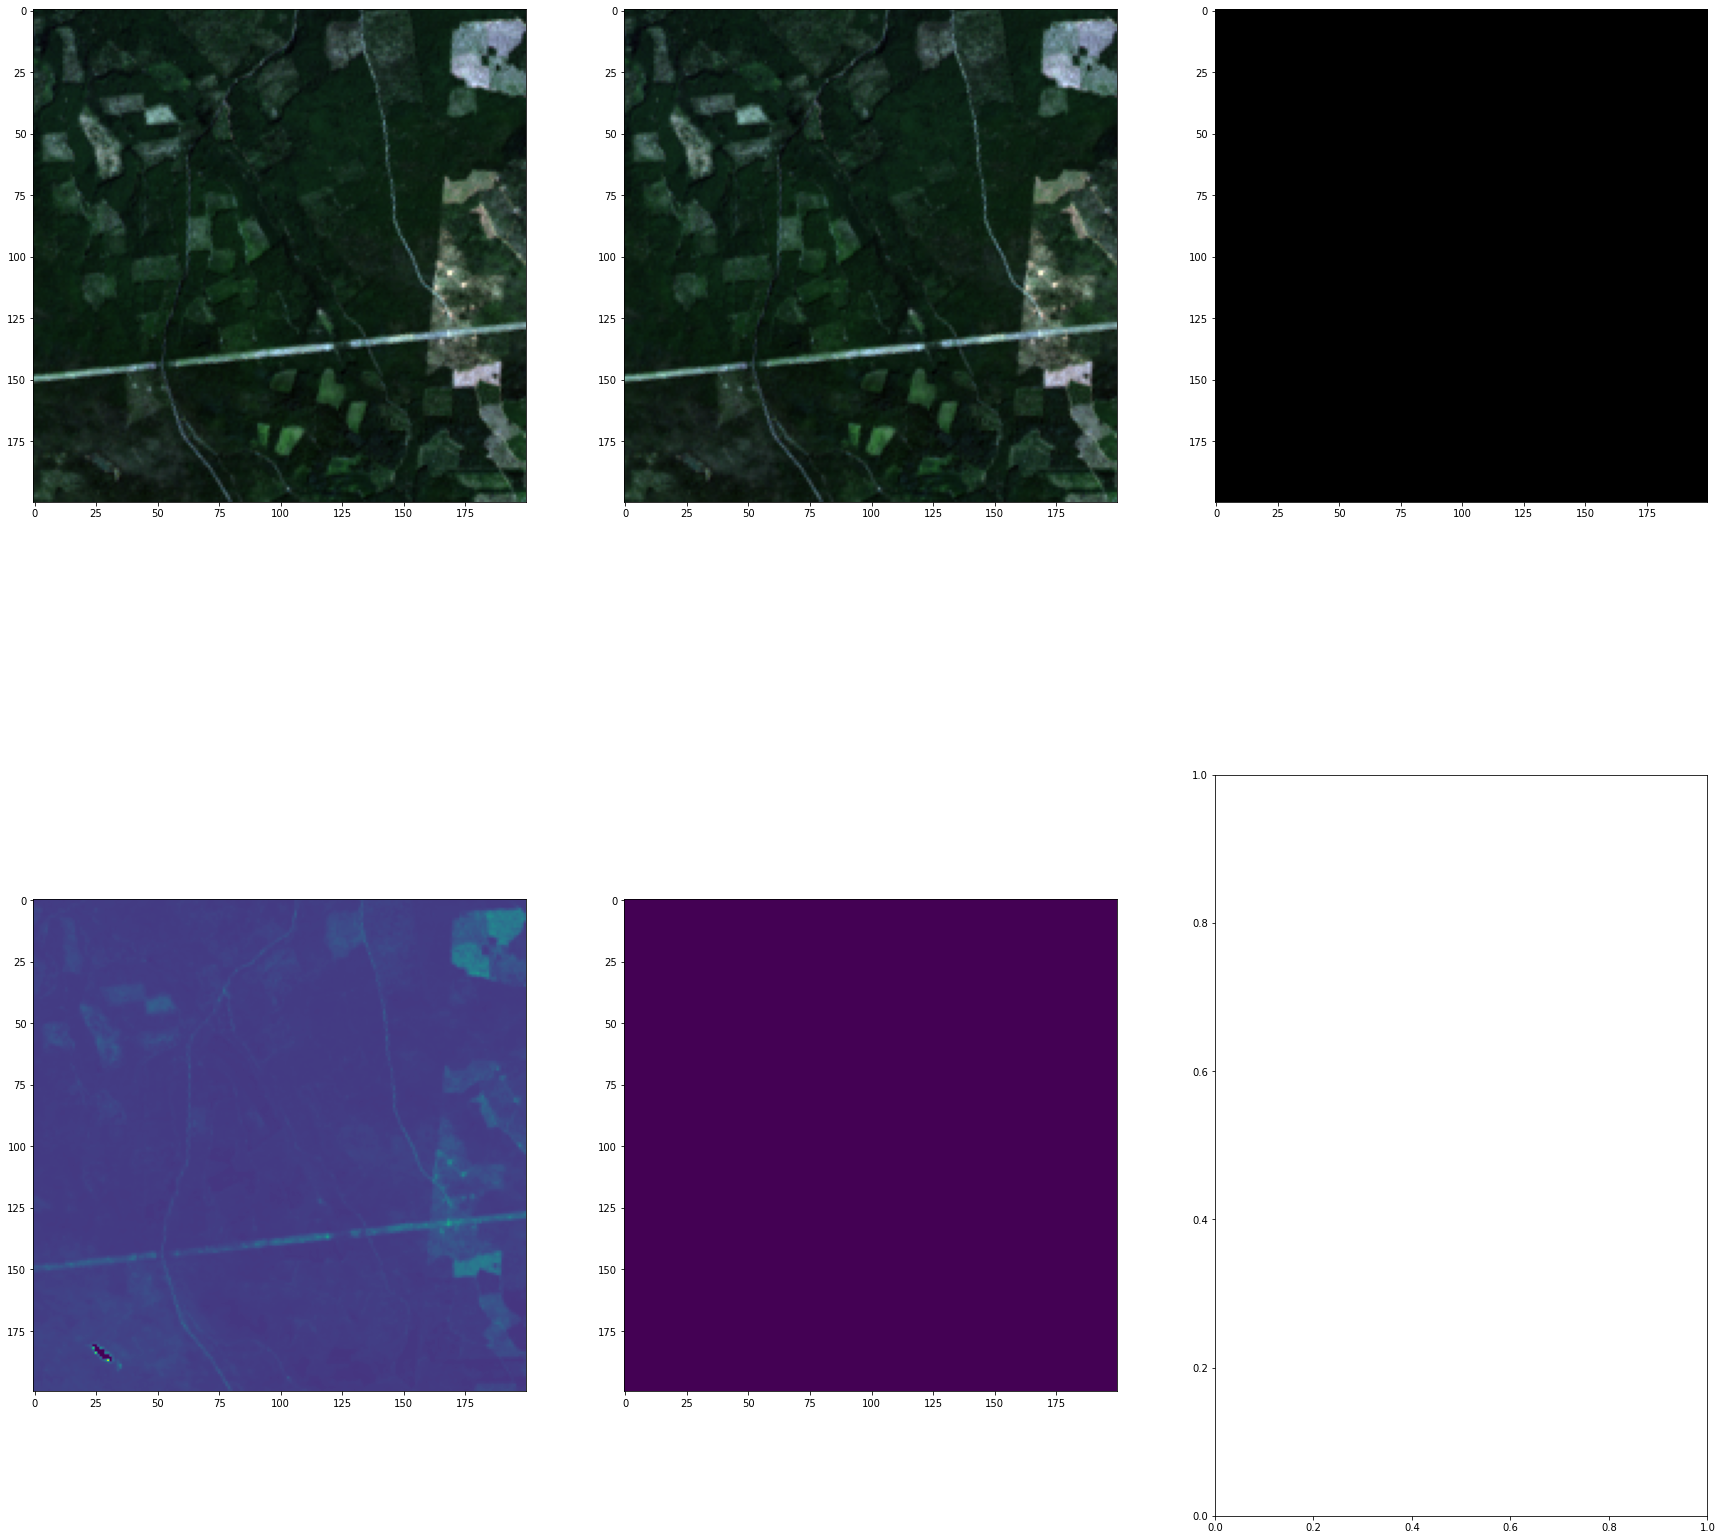

In [0]:
from pyproj import Proj, transform

#upload_file(filename)


def crop_fire(lat, long, scene_filename, radius):
  latlongProj = Proj('epsg:4326')
  with rio.open(scene_filename) as buffer:
    print(buffer)
    print(buffer.bounds)
    crsProj = Proj(buffer.crs) 
    x, y = transform(latlongProj, crsProj, lat, long)
    print(x, y)
    window = rio.windows.from_bounds(x - radius, y - radius, x + radius, y + radius, transform=buffer.transform)
    return buffer.read(window=window)

fire = df.iloc[44]
red = normalize(crop_fire(fire['LATITUDE'], fire['LONGITUDE'], f"data/{displayId}/{displayId}_B4.TIF", 3000))
green = normalize(crop_fire(fire['LATITUDE'], fire['LONGITUDE'], f"data/{displayId}/{displayId}_B3.TIF", 3000))
blue = normalize(crop_fire(fire['LATITUDE'], fire['LONGITUDE'], f"data/{displayId}/{displayId}_B2.TIF", 3000))

old_red = normalize(crop_fire(fire['LATITUDE'], fire['LONGITUDE'], f"data/{displayId}/{displayId}_B4unprocessed.TIF", 3000))
old_green = normalize(crop_fire(fire['LATITUDE'], fire['LONGITUDE'], f"data/{displayId}/{displayId}_B3unprocessed.TIF", 3000))
old_blue = normalize(crop_fire(fire['LATITUDE'], fire['LONGITUDE'], f"data/{displayId}/{displayId}_B2unprocessed.TIF", 3000))

on_fire = np.nan_to_num(normalize(crop_fire(fire['LATITUDE'], fire['LONGITUDE'], f"data/{displayId}/{displayId}_FIRE.TIF", 3000)))
ndvi = np.nan_to_num(normalize(crop_fire(fire['LATITUDE'], fire['LONGITUDE'], f"data/{displayId}/{displayId}_NDVI.TIF", 3000)))

# Stack bands
rgb = np.vstack((red, green, blue)).transpose((1,2,0))
old_rgb = np.vstack((old_red, old_green, old_blue)).transpose((1,2,0))
rgb_diff = rgb - old_rgb
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 25))

axes[0][0].imshow(old_rgb)
axes[0][1].imshow(rgb)
axes[0][2].imshow(rgb_diff)
axes[1][0].imshow(ndvi.squeeze())
print(on_fire)
axes[1][1].imshow(on_fire.squeeze())

In [0]:
# Get scenes for each fire
# Number of fires to sample
fire_samples = 2
# Fraction of scenes to take
scene_samples = .3
# fraction of area covered by samples per scene
samples_per_scene = .5
# number of 30x30m blocks in a single sample
sample_size = (32, 32)

def sample_from_scene(buffer, sample_size, center_lat, center_long, area, elapsed_time_fraction):
  """
  Randomly samples a rectangular section from a landsat image, attempting to capture the current edge of the fire.

  buffer: the landsat bands to sample from
  sample_size: a tuple (w, h) representing the dimensions of the sample to return in 30m units (resolution of landsat)
  center_lat: The latitude of the center of the fire
  center_long: The longitude of the center of the fire
  area: the total area the fire grew to
  elapsed_time_fraction: the elapsed time from the start of the fire until this scene over the total duration of the fire
  """
  pass

!mkdir data
df['scenes'] = None

for fire in df.sample(fire_samples):
  scenes = find_scenes(fire['LATITUDE'], fire['LONGITUDE'], fire['DISCOVERY_DATE'], fire['CONT_DATE'])
  # Sample from scenes (except last, which has no next scene)
  scenes = random.sample(scenes[:-1], len(scenes[:-1])*scene_samples)
  # Pair each scene with its next scene
  scene_pairs = [(scene, scenes[scenes.index(scene) + 1] for scene in scenes]
  fire['scenes'] = scene_pairs
  for (initial_scene, target_scene) in scene_pairs:
    print(initial_scene)
    #download_scene_sat_image(initial_scene)
    #download_scene_sat_image(target_scene)
print(df.head())
print(df[df['scenes'] != None].head())

#print(response)

#api.logout()

# Download images for each scene
#ee.logout()

In [0]:
# Load weather station data into memory
station_link = 'https://drive.google.com/open?id=1loqhXTyhpgm8GMjdAOpuKcoIWEOBfgWx'
station_filename = 'ghcnd-stations.txt'
download_from_drive(station_link, station_filename)
station_df = pd.read_csv(station_filename, header=None, delimiter="\t", names = ['station_id', 'lat', 'long', ''])
station_df = station_df[['station_id', 'lat', 'long']]
station_df = station_df[station_df['station_id'].str.contains("US")]
print(station_df.head())

precip_files = [#('https://drive.google.com/open?id=1wwK97X8F4xrddxIiLc23jhT0qq5Zrgfa', '1992.csv.gz'),
                #('https://drive.google.com/open?id=1a5Fveq3ThnCcrh7-rfc6onEZ5VSvFd1v', '1993.csv.gz'),
                #('https://drive.google.com/open?id=175KezgsyUiM-nK0HZlUeJzf-29_V-fLJ', '1994.csv.gz'),
                ('https://drive.google.com/open?id=1eCwvjED4NRIBnDu2AvTI9CeiPyaloWRQ', '1995.csv.gz'),
                #('https://drive.google.com/open?id=1SV59vfArbsaSw5KdFKzLpxCYEDlxOa6a', '1996.csv.gz'),

                #('https://drive.google.com/open?id=1XjbJgFAjxzxYrFti25sWLIHvWq0qX91c', '2000.csv.gz'),
                #('https://drive.google.com/open?id=1SR0U46Jf__wK3IKOwGl-mByDwlFkmYu2', '2001.csv.gz'),
                #('https://drive.google.com/open?id=1m_amlcvPrjZdL744qBKlVkmTpQ_b7Z0D', '2002.csv.gz'),
                #('https://drive.google.com/open?id=132vI6Z5a8qBV3kHygjrdAf7DO-mUcgIV', '2003.csv.gz'),
                #('https://drive.google.com/open?id=1kIB3g75zFs609BAaFlOBdaq6DzqjO3mK', '2004.csv.gz'),
                #('https://drive.google.com/open?id=1xlca2LnXN5jIMgike4v9-8C6mqg9yDWs', '2005.csv.gz'),
                #('https://drive.google.com/open?id=1uwn7VB4rTlN2ahk4YV3U64NNnn04kTLK', '2006.csv.gz'),
                #('https://drive.google.com/open?id=1Ap_pCam1p7oq2-14ltIeq5-QSVJQOvHi', '2007.csv.gz'),
                #('https://drive.google.com/open?id=1ouxz7KeNDj7El1oxnYWgkxZn3JH-RljD', '2008.csv.gz'),
                #('https://drive.google.com/open?id=1F0zrXAYzOZzHAv6nS4mrEWgLhHhLWSHJ', '2011.csv.gz')
                #('https://drive.google.com/open?id=1T3GffQ-ukgAX9cNOU3iKGVhEtvysgMwV', '2012.csv.gz'),
                #('https://drive.google.com/open?id=1AOFK7irqXZvHNgSrAwOtPmCLaJm4Q7RP', '2013.csv.gz'),
                #('https://drive.google.com/open?id=1iVhJ6FLvQYS9WKhdd9O5U07HiPQiOT4m', '2014.csv.gz'),
                #('https://drive.google.com/open?id=14Rr6Q1hWXCcGzsU0nb-A2-lU3xMSArTj', '2015.csv.gz')
                ]

def load_weather_file(weather_filename):
  print(f"Loading {precip_filename}...", end = " ")
  # Load file
  with gzip.open(precip_filename, mode='rt') as f:
    precip_df = pd.read_csv(f, names = ["station_id", "date", "label", "value", "u1", "u2", "u3", "u4"])
  # Only keep relevant data
  precip_df = precip_df.drop(["u1", "u2", "u3", "u4"], axis =1)
  precip_df = precip_df[precip_df['station_id'].str.contains("US")]
  # Convert to python types
  precip_df["date"] = pd.to_datetime(precip_df['date'], format='%Y%M%d')
  precip_df['value'] = precip_df['value'].astype('float64')
  print("cleaning...", end=' ')
  precip_df = convert_precip_units(clean_precip(precip_df))
  print("done")
  return precip_df

# Shows the most reported data columns
#print(precip_dfs[0]['label'].value_counts()[:20])
#from multiprocessing import Pool
#def parallelize_dataframe(df, func, n_cores=4):
#    df_split = np.array_split(df, n_cores)
#    pool = Pool(n_cores)
#    df = pd.concat(pool.map(func, df_split))
#    pool.close()
#    pool.join()
#    return df

def clean_precip(dt):
  """
  Given a precipitation file, returns a file with the columns station_id and date along with the core_values.
  The value of each core_value is None if it is not reported by the station, and the value reported otherwise.

  """
  core_values = ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD']
  dt = dt[dt.label.isin(core_values)]
  # converts data long form to wide form
  dt = dt.pivot_table(index=['station_id', 'date'], columns='label', values='value')
  dt.columns = dt.columns.get_level_values(0)
  return dt

def convert_precip_units(dt):
  """
  Converts temperatures to celcius, rainfall/snowfall to mm
  """
  # Maximum temp, min temp, precipitation, snowfall, snow depth, temperature at observation, average temperature
  # temp in tenths of C, precip in tenths of mm, else in mm
  for temp in ['TMAX', 'TMIN']:
    dt[temp] = dt[temp].astype('float64') / 10
  dt['PRCP'] = dt['PRCP'].astype('float64') / 10
  for val in ['SNOW', 'SNWD']:
    dt[val] = dt[val].astype('float64')
  return dt

# Clean raw precipitation data
#precip_df = convert_precip_units(clean_precip(precip_dfs))

# Combine lat and long
#precip_df = pd.merge(station_df, precip_df, how='right')
#print(precip_df.head())
#print("Saving dataframe...")
#precip_df.to_pickle("precip_df.pkl")
#upload_file('precip_df.pkl')

# Get access to all precipitation files
for (precip_link, precip_filename) in precip_files:
  download_from_drive(precip_link, precip_filename)

# Load precipitation data into memory
precip_dfs = None
for (_, precip_filename) in precip_files:
    precip_df = load_weather_file(precip_filename)
    if precip_dfs is None:
      precip_dfs = precip_df
    else:
      precip_dfs = precip_dfs.append(precip_df)

print(precip_dfs.head())
print(precip_dfs.shape[0])


In [0]:
# Create a column in the fire database consisting of aggregated weather for the week preceding the fire
def get_preceding_weather(discovery_date):
  start_date = discovery_date - pd.Timedelta(7, unit='D') 
  print(start_date)
  preceding_week = precip_df.loc[(precip_df['date'] > start_date) & (precip_df['date'] <= discovery_date)]
  print(len(preceding_week))
  aggr = preceding_week.agg(preceding_prcp=('PRCP', 'sum'), preceding_max_tmax=('TMAX', 'max'), preceding_avg_tmax=('TMAX', 'mean'), preceding_avg_tmin=('TMIN', 'mean'), preceding_avg_snow=('SNOW', 'mean'), preceding_avg_snwd=('SNWD', 'mean'))
  print(aggr)
  return aggr
df = dfl2
print(precip_df.head())
df['PRECEDING_PRCP'], df['PRECEDING_MAX_TMAX'], df['PRECEDING_AVG_TMAX'], df['PRECEDING_AVG_TMIN'], df['PRECEDING_AVG_SNOW'], df['PRECEDING_AVG_SNWD'] = zip(*map(get_preceding_weather, df['DISCOVERY_DATE']))
print(df.columns)
print(df.shape[0])
print(df.head())

In [0]:
download_from_drive('https://drive.google.com/open?id=1ywUJqNmfkvZxtebK2v0lLn-yTeWsEDS7', 'precip_df.pkl')
precip_df = pd.read_pickle("precip_df.pkl")
print(precip_df.columns)
print(precip_df.shape[0])
print(precip_df.head())

In [0]:
from pylandsat import  Scene
scene = Scene(os.path.join(os.getcwd(), 'data', scene["displayId"]))
print(scene.available_bands())
print(scene.product_id)
print(scene.sensor)
print(scene.date)

# Access MTL metadata
print(scene.mtl['IMAGE_ATTRIBUTES']['CLOUD_COVER_LAND'])
print(scene.mtl.keys())

# Quality band
plt.imshow(scene.quality.read())

# Access band data
nir = scene.nir.read(1)
red = scene.red.read(1)
ndvi = (nir + red) / (nir - red)

# Access band metadata
print(scene.nir.bname)
print(scene.nir.fname)
print(scene.nir.profile)
print(scene.nir.width, scene.nir.height)
print(scene.nir.crs)

# Use reflectance values instead of DN
nir = scene.nir.to_reflectance()

# ..or brightness temperature
tirs = scene.tirs.to_brightness_temperature()

# Save file to disk
with rasterio.open('temperature.tif', 'w', **scene.tirs.profile) as dst:
    dst.write(tirs, 1)

In [0]:
import rasterio.features
import rasterio.warp

def plot_rgb(display_file):
  with rio.open(f'/content/data/{display_file}/{display_file}_combined.TIF') as img:
    red = normalize(img.read(band_indices["B4"]))
    green = normalize(img.read(band_indices["B3"]))
    blue = normalize(img.read(band_indices["B2"]))
    # Stack bands
    rgb = np.dstack((red, green, blue))
    # View the color composite
    plt.imshow(rgb)
display_file = "LC08_L1TP_074014_20150627_20170226_01_T1"
!ls data/{display_file}
#plot_rgb(display_file)

In [0]:


from datetime import datetime

import pandas as pd
from shapely.geometry import Point
from pylandsat import Catalog, Product, Scene
import numpy as np
import matplotlib.pyplot as plt

catalog = Catalog()

begin = datetime(2000, 1, 1)
end = datetime(2010, 1, 1)
geom = Point(4.34, 50.85)

# Results are returned as a pandas dataframe
scenes = catalog.search(
    begin=begin,
    end=end,
    geom=geom,
    sensors=['LC08']
)

# Get the product ID of the scene with the lowest cloud cover
scenes = scenes.sort_values(by='cloud_cover', ascending=True)
product_id = scenes.index[0]

# Download the scene
product = Product(product_id)
!mkdir data/
product.download(out_dir='data')

scene = Scene('data/LE07_L1TP_205050_19991104_20170216_01_T1')
print(scene.available_bands())
print(scene.product_id)
print(scene.sensor)
print(scene.date)

# Access MTL metadata
print(scene.mtl['IMAGE_ATTRIBUTES']['CLOUD_COVER_LAND'])

# Quality band
plt.imshow(scene.quality.read())



In [0]:
!ls data/LC80130312018191LGN00/

In [0]:
import geomac_wildfires
data = geomac_wildfires.get_all_perimeters()
features = data['features'][0]
print(features['type'])
print(features['properties'])
print(features['geometry'])
print(data['type'])

In [0]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
def est_weather_map_at(start_date, weather_val):
  mask = (precip_small['date'] >= start_date) & (precip_small['date'] < start_date + pd.Timedelta('7 days')) & (~precip_small[weather_val].isnull()) 
  mask = mask & (precip_small['lat'] > 19.5) & (precip_small['lat'] < 65) & (precip_small['long'] > -161.75583) & (precip_small['long'] < -68.01197)
  dat = precip_small.loc[mask]
  y = dat['lat']
  x = dat['long']
  z = dat[weather_val]
  
  if dat.shape[0] == 0:
    print(start_date)
    raise Exception("No weather data for the given date")

  xi = np.arange(-161, -68, .1)
  yi = np.arange(19.5, 65, .1)
  xi,yi = np.meshgrid(xi,yi)
  zi_fill = griddata((x,y),z,(xi,yi),method='nearest')
  zi = griddata((x,y),z,(xi,yi),method='linear')
  mask = np.isnan(zi)
  zi[mask] = zi_fill[mask]
  return xi, yi, zi, x, y, z
# Interpolate weather data
# target grid to interpolate to
#print(precip_small['TMAX'].unique())
plot_date = '2008-1-2'
xi, yi, zi, x, y, z = est_weather_map_at(pd.to_datetime(plot_date), 'PRCP')

fig = plt.figure()
ax = fig.add_subplot(111)
#plt.plot(x,y,'k.', alpha=0.01)
CS = plt.contourf(xi,yi,zi,100)
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('mm')
plt.title('Interpolated Rainfall')
plt.xlabel('longitude',fontsize=16)
plt.ylabel('latitude',fontsize=16)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
plt.close(fig)


def est_weather_val(lat, long, xi, yi, zi):
  # TODO this can be more efficient
  longs = xi[0]
  lats = yi[:, 0]

  ilong = (np.abs(longs - long)).argmin()
  ilat = (np.abs(lats - lat)).argmin()
  return zi[ilat, ilong]




In [0]:
# Create new database consisting only of rows that are relevant to fires (time of fire plus a week)

# Group into weeks. Result of this is the ending day is the date.
gb = precip_df.groupby([pd.Grouper('station_id'), pd.Grouper(key='date',freq='W')])
precip_small = gb.agg({'lat': 'mean', 'long': 'mean', 'TMAX': 'max', 'TMIN': 'min', 'PRCP': 'sum', 'SNOW': 'sum', 'SNWD': 'sum'})
precip_small.reset_index(inplace=True)  

print(precip_small.head())
print(precip_small.shape[0])

In [0]:
print(est_weather_val(34.411667, -112.401667, xi, yi, zi))
def calc_weather(row, val='TMAX'):
  date = row['DISCOVERY_DATE'].iloc[0]
  xi, yi, zi, x, y, z = est_weather_map_at(date, val)
  return row.apply(lambda p: est_weather_val(p['LATITUDE'],p['LONGITUDE'], xi, yi, zi), axis=1)

# Make sure you remove all fires that are not during time periods we have weather data for.
last_weather_date = max(precip_small['date'])
first_weather_date = min(precip_small['date'])
df_test = df[(df['DISCOVERY_DATE'] < last_weather_date) & (df['DISCOVERY_DATE'] >= first_weather_date)].reset_index(drop=True)
print("Calculating weather for %d fires" % df_test.shape[0])
gb = df_test.groupby(pd.Grouper(key='DISCOVERY_DATE', freq='W'))
for col in ['TMAX', 'TMIN', 'PRCP', 'SNOW']:
  temp = gb.apply(calc_weather, val=col).transpose()
  df_test["ABS_" + col] = temp.reset_index(drop=True)
print(df_test[['LATITUDE', 'LONGITUDE', 'ABS_TMAX', 'ABS_TMIN', 'ABS_PRCP', 'ABS_SNOW']].head())
#df['TEMP_THIS_WEEK'] = df.apply(lambda r: , axis=1)

In [0]:
# Calculate yearwise means
station_monthly_means = precip_small.groupby(['station_id', precip_small.date.dt.month]) \
  .agg({'lat': 'mean', 'long' : 'mean', 'TMAX' : 'mean', 'TMIN': 'mean', 'PRCP': 'mean', 'SNOW': 'mean', 'SNWD': 'mean'}) \
  .reset_index().rename(columns={'date': 'month'})
df_test['month'] = df_test['DISCOVERY_DATE'].dt.month

def est_mean_weather_map_at(month, weather_val):
  mask = (station_monthly_means['month'] == month) & (~station_monthly_means[weather_val].isnull()) 
  mask = mask & (station_monthly_means['lat'] > 19.5) & (station_monthly_means['lat'] < 65) & (station_monthly_means['long'] > -161.75583) & (station_monthly_means['long'] < -68.01197)
  dat = station_monthly_means.loc[mask]
  y = dat['lat']
  x = dat['long']
  z = dat[weather_val]
  
  if dat.shape[0] == 0:
    print(month)
    raise Exception("No mean data for the given date")

  xi = np.arange(-161, -68, .1)
  yi = np.arange(19.5, 65, .1)
  xi,yi = np.meshgrid(xi,yi)
  zi_fill = griddata((x,y),z,(xi,yi),method='nearest')
  zi = griddata((x,y),z,(xi,yi),method='linear')
  mask = np.isnan(zi)
  zi[mask] = zi_fill[mask]
  return xi, yi, zi, x, y, z

xi, yi, zi, x, y, z = est_mean_weather_map_at(1, 'TMAX')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x,y,'k.', alpha=0.01)
CS = plt.contourf(xi,yi,zi,100)
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('degrees C')
plt.title('Interpolated mean temperature maximums of the month of January')
plt.xlabel('longitude',fontsize=16)
plt.ylabel('latitude',fontsize=16)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
plt.close(fig)

def calc_weather_mean(row, val='TMAX'):
  month = row['month'].iloc[0]
  xi, yi, zi, x, y, z = est_mean_weather_map_at(month, val)
  return row.apply(lambda p: est_weather_val(p['LATITUDE'],p['LONGITUDE'], xi, yi, zi), axis=1)

last_weather_month = max(station_monthly_means['month'])
first_weather_month = min(station_monthly_means['month'])
df_test = df_test[(df_test['month'] <= last_weather_month) & (df_test['month'] >= first_weather_month)].reset_index(drop=True)
print("Calculating mean weather...")
gb = df_test.groupby('month')
for col in ['TMAX', 'TMIN', 'PRCP', 'SNOW']:
  temp = gb.apply(calc_weather_mean, val=col).transpose()
  df_test["MEAN_" + col] = temp.reset_index(drop=True)
print(df_test[['month', 'LATITUDE', 'LONGITUDE', 'ABS_TMAX', 'MEAN_TMAX', 'ABS_PRCP', 'MEAN_PRCP']].groupby(['LATITUDE', 'LONGITUDE', 'month']).head())


In [0]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
 
models = [LinearRegression(), Lasso(), AdaBoostRegressor(), BaggingRegressor(), GradientBoostingRegressor()]
dfl2 = df_test
X = dfl2[["ABS_TMAX", "MEAN_TMAX", "ABS_PRCP", "MEAN_PRCP"]]
#X['ABS_TMAX'].fillna(, inplace=True)
X['DIFF_TMAX'] = X["ABS_TMAX"] - X['MEAN_TMAX']
X['FRAC_MEAN_PRCP'] = (X["ABS_PRCP"]/X['MEAN_PRCP']).fillna(0).replace(np.inf, 0)
#X = X.drop(['M'])
X# = pd.get_dummies(X, columns=["STAT_CAUSE_DESCR"], prefix=["cause"])

for col in X.columns:
  print(str(col) + ": " + str((X[col] > 1000).sum()))

y = dfl2["FIRE_SIZE"]
print("y: " + str(y.isnull().sum()))

print(X.head())
print(X.shape[0])
for model in models:
  scores = []
  rmss = []
  kfold = KFold(n_splits=3, shuffle=True, random_state=42)
  for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train], y.iloc[train])
    score = model.score(X.iloc[test], y.iloc[test])
    scores.append(score)
    y_predicted = model.predict(X.iloc[test])
    rmss.append(sqrt(mean_squared_error(y.iloc[test], y_predicted)))
 

  print(model)
  print("R^2:")
  print(scores)
  print("RMS:")
  print(rmss)

  print(models[0].coef_)
  top_i = np.abs(models[0].coef_).argsort()[-6:][::-1]
  # Print most import coefficients
  print([x for x in zip(X.columns[top_i], models[0].coef_[top_i])])
  # Most